In [28]:
import copy
import random
import time
import pandas as pd
import matplotlib.pyplot as plt

from greedy import GreedyBot
from dynamic_programming import DynamicProgrammingBot
from ml import MLBot
from yahtzee_game import YahtzeeGame
from utils import calculate_score


In [29]:
CATS = list(YahtzeeGame().score_sheet.keys())

UPPER_CATS = ("aces", "twos", "threes", "fours", "fives", "sixes")
LOWER_CATS = tuple(c for c in CATS if c not in UPPER_CATS)

NUMERIC_SCORES = {
    "aces": 1, "twos": 2, "threes": 3, "fours": 4, "fives": 5, "sixes": 6
}
UPPER_BY_FACE = {1:"aces", 2:"twos", 3:"threes", 4:"fours", 5:"fives", 6:"sixes"}


def is_yahtzee_roll(dice_sorted):
    return len(set(dice_sorted)) == 1


def upper_sum(score_sheet):
    return sum(score_sheet[c] for c in UPPER_CATS)


def upper_bonus(score_sheet):
    return 35 if upper_sum(score_sheet) >= 63 else 0


def lower_sum(score_sheet):
    return sum(score_sheet[c] for c in LOWER_CATS)


def final_total(score_sheet, yahtzee_bonus_count):
    return upper_sum(score_sheet) + upper_bonus(score_sheet) + lower_sum(score_sheet) + 100 * yahtzee_bonus_count


def score_category_with_joker(dice_sorted, choice, score_sheet):
    """
    Returns (category_points, bonus100_awarded_this_turn).

    Assumes utils.calculate_score is STANDARD scoring (no 'yahtzee counts as straight/fullhouse').
    """
    joker_active = is_yahtzee_roll(dice_sorted) and (score_sheet.get("yahtzee") == 50)

    bonus100 = 100 if joker_active else 0

    if not joker_active:
        return calculate_score(dice_sorted, choice), bonus100

    face = dice_sorted[0]
    forced_upper = UPPER_BY_FACE[face]
    upper_open = (score_sheet.get(forced_upper) is None)

    lower_open_exists = any(score_sheet.get(c) is None for c in LOWER_CATS)

    # legality enforcement / correction (bots should already obey; this prevents crashes)
    if upper_open and choice != forced_upper:
        choice = forced_upper

    if (not upper_open) and lower_open_exists and (choice in UPPER_CATS):
        # pick *some* open lower category; we'll let the bot's logic handle the real choice elsewhere
        for c in LOWER_CATS:
            if score_sheet.get(c) is None:
                choice = c
                break

    # scoring overrides when NOT forced into the corresponding upper
    if not upper_open:
        if choice == "fullhouse":
            return 25, bonus100
        if choice == "smstraight":
            return 30, bonus100
        if choice == "lgstraight":
            return 40, bonus100

    return calculate_score(dice_sorted, choice), bonus100


In [30]:
def make_roll_table(rng, n_turns):
    """
    For each remaining turn, pre-generate:
      roll0: 5 values (initial roll)
      roll1: 5 values (values used when rerolling dice positions on reroll #1)
      roll2: 5 values (values used when rerolling dice positions on reroll #2)
    """
    table = []
    for _ in range(n_turns):
        roll0 = [rng.randint(1, 6) for _ in range(5)]
        roll1 = [rng.randint(1, 6) for _ in range(5)]
        roll2 = [rng.randint(1, 6) for _ in range(5)]
        table.append((roll0, roll1, roll2))
    return table


def apply_reroll_by_mask(dice_sorted, mask_int, roll_values_5):
    """
    dice_sorted: list length 5, assumed sorted
    mask_int: bit i=1 reroll that position i (in the CURRENT sorted dice)
    roll_values_5: list length 5, new values for each position if rerolled
    """
    dice = list(dice_sorted)
    for i in range(5):
        if (mask_int >> i) & 1:
            dice[i] = roll_values_5[i]
    dice.sort()
    return dice


In [31]:
def random_small_state(rng, min_open=1, max_open=5):
    """
    Returns a plausible-ish score_sheet dict with k open categories (None),
    and all others filled with plausible values.
    """
    k = rng.randint(min_open, max_open)
    open_cats = rng.sample(CATS, k)

    sheet = {}
    for c in CATS:
        if c in open_cats:
            sheet[c] = None
            continue

        if c in NUMERIC_SCORES:
            face = NUMERIC_SCORES[c]
            count = rng.randint(0, 5)
            sheet[c] = face * count
        elif c in ("threekind", "fourkind", "chance"):
            sheet[c] = rng.randint(0, 30)
        elif c == "fullhouse":
            sheet[c] = 25 if rng.random() < 0.25 else 0
        elif c == "smstraight":
            sheet[c] = 30 if rng.random() < 0.25 else 0
        elif c == "lgstraight":
            sheet[c] = 40 if rng.random() < 0.20 else 0
        elif c == "yahtzee":
            sheet[c] = 50 if rng.random() < 0.15 else 0
        else:
            sheet[c] = 0

    return sheet


In [ ]:
def play_small_game(bot, start_sheet, roll_table):
    """
    Plays exactly len(open categories) turns, using the pre-generated roll_table.
    Returns: (total_score, yahtzee_bonus_count, final_sheet)
    """
    sheet = copy.deepcopy(start_sheet)
    yahtzee_bonus_count = 0

    open_count = sum(v is None for v in sheet.values())
    assert open_count == len(roll_table), "roll_table length must match number of open categories"

    for turn_i in range(open_count):
        roll0, roll1, roll2 = roll_table[turn_i]

        dice = sorted(roll0)

        # two rerolls max
        # rolls_left passed matches your bots' expectation (2 then 1)
        for step, (rolls_left, roll_vals) in enumerate([(2, roll1), (1, roll2)], start=1):
            mask = bot.choose_best_keep(dice, rolls_left, sheet)
            if mask == 0:
                break
            dice = apply_reroll_by_mask(dice, mask, roll_vals)

        # choose category and score it
        choice = bot.choose_best_category(dice, sheet)

        # safety: if bot returns None, pick any open category
        if choice is None or sheet.get(choice) is not None:
            for c in CATS:
                if sheet[c] is None:
                    choice = c
                    break

        pts, bonus100 = score_category_with_joker(dice, choice, sheet)
        if bonus100:
            yahtzee_bonus_count += 1

        # store only category points in the sheet (bonus tracked separately)
        sheet[choice] = pts

    return final_total(sheet, yahtzee_bonus_count), yahtzee_bonus_count, sheet


In [33]:
N_STATES = 100
BASE_SEED = 67

bots = {
    "Greedy": GreedyBot(),
    "DP": DynamicProgrammingBot(),
    "ML": MLBot(),
}

records = []

t0 = time.perf_counter()

for i in range(N_STATES):
    state_rng = random.Random(BASE_SEED + i)

    # make a small state (1..5 open)
    start_sheet = random_small_state(state_rng, min_open=1, max_open=5)
    open_count = sum(v is None for v in start_sheet.values())

    # pre-generate all rolls for those remaining turns (same for every bot)
    roll_table = make_roll_table(state_rng, open_count)

    for bot_name, bot in bots.items():
        start = time.perf_counter()
        total, ybonus_ct, final_sheet = play_small_game(bot, start_sheet, roll_table)
        dt = time.perf_counter() - start

        records.append({
            "game_id": i,
            "open_k": open_count,
            "bot": bot_name,
            "total": total,
            "yahtzee_bonus_count": ybonus_ct,
            "upper": upper_sum(final_sheet),
            "upper_bonus": upper_bonus(final_sheet),
            "lower": lower_sum(final_sheet),
            "runtime_s": dt,
            "yahtzee_enabled_start": (start_sheet.get("yahtzee") == 50),
        })

elapsed = time.perf_counter() - t0
df = pd.DataFrame(records)

elapsed


829.8322745829355

In [34]:
summary = (
    df.groupby("bot")["total"]
      .agg(["count", "mean", "std", "min", "median", "max"])
      .sort_values("mean", ascending=False)
)
summary

# win rates by game (ties split)
pivot = df.pivot(index="game_id", columns="bot", values="total")
wins = {b: 0.0 for b in bots.keys()}

for game_id, row in pivot.iterrows():
    best = row.max()
    winners = [b for b, v in row.items() if v == best]
    share = 1.0 / len(winners)
    for w in winners:
        wins[w] += share

win_rates = pd.Series({k: v / N_STATES for k, v in wins.items()}).sort_values(ascending=False)
win_rates


DP        0.586667
Greedy    0.366667
ML        0.046667
dtype: float64

<Figure size 640x480 with 0 Axes>

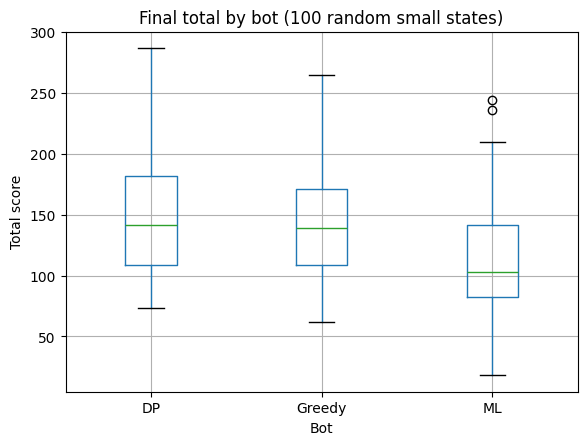

In [35]:
# Boxplot of totals
plt.figure()
df.boxplot(column="total", by="bot")
plt.suptitle("")  # remove default
plt.title("Final total by bot (100 random small states)")
plt.xlabel("Bot")
plt.ylabel("Total score")
plt.show()


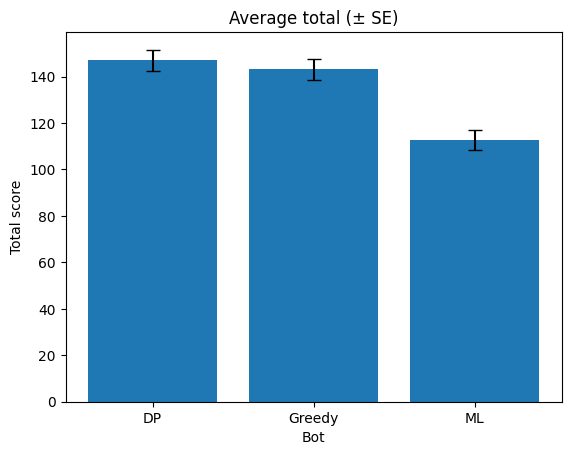

In [36]:
# Mean with standard error bars
plt.figure()
means = df.groupby("bot")["total"].mean()
ses = df.groupby("bot")["total"].std() / (df.groupby("bot")["total"].count() ** 0.5)

plt.bar(means.index, means.values, yerr=ses.values, capsize=5)
plt.title("Average total (± SE)")
plt.xlabel("Bot")
plt.ylabel("Total score")
plt.show()
